# Trabalho Pratico 1 - Sistema de Tráfego
### Grupo 27
#### LCC 2024/2025
#### Rafaela Antunes Pereira A102527 
#### Gonçalo Gonçalves Barroso A102931 
#### Ricardo Eusébio Cerqueira A102878

## Explicação do Projeto
Neste trabalho pretende-se realizar um sistema de tráfego,representado por um grafo orientado ligado, no qual os seus nodos denotam pontos de acesso e os arcos vias de comunicação só com um sentido. tendo as seguintes condições:
* O grafo tem de ser ligado, ou seja entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2 \leadsto n_1$
* Os nodos do grafo tem de ser gerados aletoriamente com  $N \in\{6..10\}$  
* Cada nodo tem um numero aleatório de descendentes $d\in\{1 .. 3\}\,$ com destinos igualmente gerados aleatoriamente
* Se  existirem “loops” ou destinos repetidos, deve-se gerar outro grafo

Pretende-se que depois do grafo estar gerado pode-se realizar:
* Determinar o maior número de vias que é possivel remover mantendo o grafo ligado

##  Função que gera aleatoriamente um MultiDiGraph ligado
    Esta função segue um loop infinito, que cria um MultiDiGraph. Um MultiDiGraph permite que haja mais de uma aresta entre um par de nós, e optamos por utilizar este tipo de grafo uma vez que esta funçao deve gerar novos grafos até atingirmos um grafo sem arestas repetidas.
    Para além disso, esta função verifica se tem loops, caso isso aconteça ou o grafo não seja ligado, deverá gerar outros grafos até obter um ideal.

In [40]:
def gerargrafo():
    while True:
        Grafo = nx.MultiDiGraph() 

        numero_nos = random.randint(6, 10)
        for i in range(1, numero_nos + 1):
            Grafo.add_node(i)

        for n in Grafo.nodes:
            num_descendentes = random.randint(1, 3)
    
            destinos = [d for d in Grafo.nodes]  
            for x in range(num_descendentes):  
                if destinos:  
                    destino = random.choice(destinos)  
                    Grafo.add_edge(n, destino)  

                    
        loops = []
        arestas_repetidas = []
        for n in Grafo.nodes:
            sucessores = list(Grafo.successors(n))
            if n in sucessores:
                loops.append(n)
            
        arestas = list(Grafo.edges)     
        for (o, d,k) in arestas:
            if k > 0:
                arestas_repetidas.append((o, d,k))
            

        if not loops and not arestas_repetidas and nx.is_strongly_connected(Grafo)  :
            return Grafo
        print("O Grafo com as arestas:", arestas)

        if not nx.is_strongly_connected(Grafo):
            print("Não é um grafo orientado ligado")
            
        if loops :
            print("É um grafo com loop")
            print(loops)
        
        if arestas_repetidas:
            print("É um grafo com repetições")
            print(arestas_repetidas)

## Função que remove o maior número de arestas possíveis mantendo sua conectividade forte
A função cria um solver que sera utilizado para determinar se as arestas podem ser removidas ou não, mantendo a conectividade forte.
Para cada aresta no grafo, é criada uma variável booleana, de seguida a função itera sobre cada aresta e remove-a do grafo. Após remover, a função verifica se o grafo ainda é fortemente conectado, se não for, a aresta é adicionada de volta ao grafo, repetindo este método até termos o grafo ideal.


In [41]:

def arestasdesn(grafo):
    solver = Solver()
    A = list(grafo.edges(keys=True))  
    
    V = {}
    for (o, d, k) in A:
        V[(o, d, k)] = Bool(f'aresta_{o}_{d}_{k}')
    
    for (o, d, k) in A:
        grafo.remove_edge(o, d, k)  
        if not nx.is_strongly_connected(grafo):
            solver.add(V[(o, d, k)] == False)  
            grafo.add_edge(o, d, key=k)  
        else:
            solver.add(V[(o, d, k)] == True)  
    
    solver.add(Sum([If(V[(o, d, k)], 1, 0) for (o, d, k) in A]) <= len(A))
    
    if solver.check() == sat:
        modelo = solver.model()
        arestas_removidas = [(o, d, k) for (o, d, k) in A if is_true(modelo[V[(o, d, k)]])]
        
        # Remove as arestas do grafo
        grafo.remove_edges_from(arestas_removidas)
        
        # Visualiza o grafo após a remoção das arestas
        pos = nx.spring_layout(grafo)
        nx.draw(grafo, pos=pos, with_labels=True, node_size=1000)
        plt.show()
        
        return arestas_removidas
    else:
        print("Nenhuma solução encontrada!")
        return []


### Função para gerar o subMultiDiGrafo com numero minimo de arestas
Para encontrar o subgrafo fortemente conexo $ S $ com o número mínimo de arestas removidas a partir de um grafo direcionado $G$, utilizamos um solver chamado Solver, e um dicionário $V$, onde vamos armazenar as variáveis binárias que indicam se uma aresta pertence ao subgrafo resultante $S$.

Sendo $E$ o conjunto de arestas de $G$, a variável $ V_{o,d,k} = 1 \iff (o,d,k) \in S $

Adicionalmente, para garantir que o subgrafo resultante $S$ seja fortemente conexo, removemos iterativamente as arestas e verificamos se o grafo permanece conexo. Se a remoção de uma aresta de $V$ desconecta o grafo, adicionamos a restrição no solver para que ela permaneça no subgrafo.

$$
\forall s, d \in V, \space \exists \text{ caminho de } s \text{ para } d
$$

Para minimizar o numero de arestas removidas, a soma das arestas presentes no sugGrafo $S$ pode ser expressa assim:
$$
\sum_{(o,d,k) \in E} V{o,d,k} \leq |E|
$$

Para representar que certas arestas são removidas, podemos expressar isso de forma condicional:
$$
V_{o,d,k} = 0 \iff \text{a aresta } (o,d,k) \text{ foi removida}
$$

O Grafo com as arestas: [(1, 2, 0), (1, 5, 0), (2, 5, 0), (3, 6, 0), (3, 4, 0), (3, 3, 0), (4, 3, 0), (4, 4, 0), (5, 5, 0), (6, 2, 0), (6, 5, 0), (6, 3, 0)]
Não é um grafo orientado ligado
É um grafo com loop
[3, 4, 5]
O Grafo com as arestas: [(1, 3, 0), (1, 6, 0), (2, 4, 0), (2, 5, 0), (2, 3, 0), (3, 8, 0), (4, 2, 0), (4, 3, 0), (5, 3, 0), (5, 1, 0), (6, 6, 0), (6, 4, 0), (7, 3, 0), (7, 7, 0), (7, 1, 0), (8, 5, 0), (8, 7, 0)]
É um grafo com loop
[6, 7]
O Grafo com as arestas: [(1, 2, 0), (1, 5, 0), (2, 1, 0), (3, 4, 0), (3, 3, 0), (4, 1, 0), (5, 6, 0), (5, 2, 0), (6, 6, 0), (6, 3, 0)]
É um grafo com loop
[3, 6]
O Grafo com as arestas: [(1, 9, 0), (1, 6, 0), (2, 9, 0), (3, 2, 0), (3, 6, 0), (4, 6, 0), (5, 9, 0), (6, 3, 0), (6, 6, 0), (6, 9, 0), (7, 6, 0), (8, 3, 0), (9, 1, 0), (9, 1, 1)]
Não é um grafo orientado ligado
É um grafo com loop
[6]
É um grafo com repetições
[(9, 1, 1)]


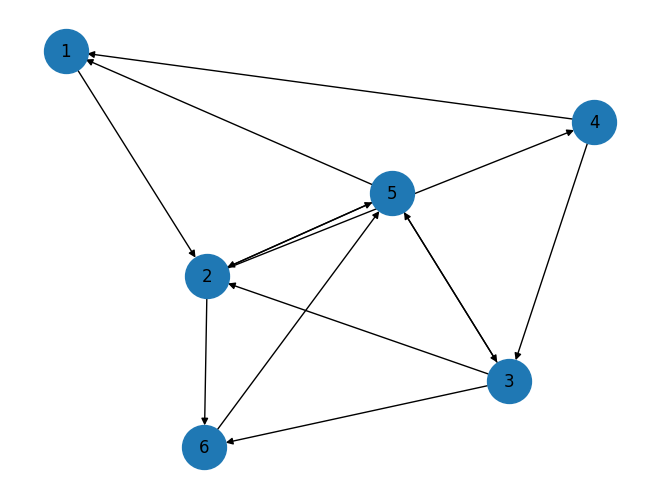

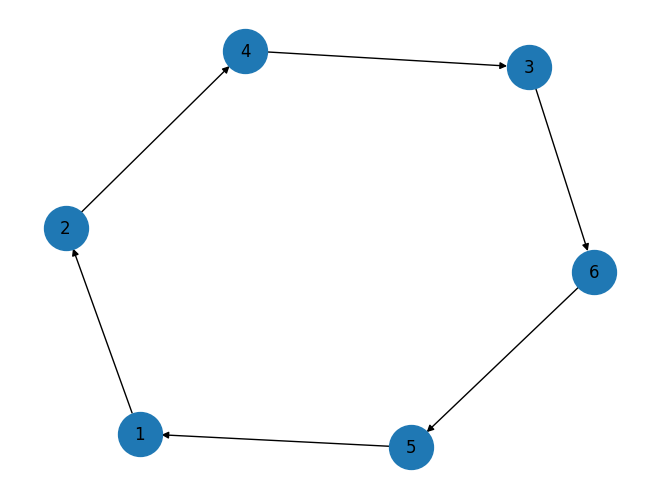

O número máximo de arestas removidas é: 7


In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from z3 import *

Grafo = gerargrafo()
pos = nx.spring_layout(Grafo)
nx.draw(Grafo,pos=pos,with_labels=True,node_size=1000)
plt.show()


arestas_removidas = arestasdesn(Grafo)
print(f"O número máximo de arestas removidas é: {len(arestas_removidas)}")